In [1]:
# install our package
! pip install .

Processing /Users/aidensmac/Documents/STA663/663-Final-Project
  Created wheel for Sinkhorn-663: filename=Sinkhorn_663-0.1-cp37-cp37m-macosx_10_9_x86_64.whl size=71857 sha256=c427d932d08c238459c064ef6e5473db714a1d64ec40ceb360524d2b299642a9
  Stored in directory: /Users/aidensmac/Library/Caches/pip/wheels/15/7b/42/02fb0596137c6b0d9d9d339e39864bb8e0e21c04ccefcf74f6
Successfully built Sinkhorn-663
  Attempting uninstall: Sinkhorn-663
    Found existing installation: Sinkhorn-663 0.1
    Uninstalling Sinkhorn-663-0.1:
      Successfully uninstalled Sinkhorn-663-0.1


In [15]:
from Sinkhorn_663 import Sinkhorn, log_domain_sinkhorn_2, Sinkhorn_numba, Sinkhorn_numba_parallel
from Sinkhorn_663 import sample_to_prob_vec, sample_to_prob_vec_nD
from Skh_cpp import Sinkhorn_cpp
import numpy as np
import matplotlib.pyplot as plt

## 2.1 Basic implementation

First, we follow the above description of algorithm to implement it in plain Python as a baseline. We use the functions in package *numpy* to do matrix operations. The Sinkhorn distance and iteration times would be returned. As in the above description, the algorithm could calculate the matrix $P^{\lambda}$ by Sinkhorn's fixed point iteration $(u, v) \leftarrow (r./Kv, c./K'u)$. Furthermore, the iteration could been simplified to one single iteration $u\leftarrow 1./(\tilde K(c./K'u))$. We use $|u_{new} - u|<tol$ as the stopping criterion.

In [3]:
def Sinkhorn_plain(r, C, M, lamda, tol = 1e-6, maxiter = 10000):
    M = M[r > 0]
    r = r[r > 0]
    K = np.exp(-lamda * M)
    N = np.shape(C)[1]
    u = np.ones((len(r), N)) / len(r)
    K_tilde = np.diag(1/r) @ K
    d_prev = np.repeat(2., N)
    d = np.ones(N) + 0.5
    for i in range(maxiter):
        u_new = 1/(K_tilde @ (C / (K.T @ u)))
        if np.max(np.abs(u_new - u)) <= tol:
            break
        u = u_new
    v = C/(K.T @ u)
    d = np.sum(u * ((K * M) @ v), axis = 0)
    return d[0], i

### 2.1.1 Test and Check results

To verify the correctness of our implementation, we generate some simulation data and test the algorithm on it. Further optimized algorithms would also be tested on them to check results and compare performance. 

As a start, we consider the situation where the empirical measures $r$ and $c$ come from a same distribution. We generate two groups of samples from a same distribution $\text{Beta}(1, 2)$, use the function *sample_to_prob_vec* to convert samples to vectors and cost matrix as inputs, and calculate the distance by our function. Here we choose sample size $N = 3000$, $\text{maxiter} = 10000$, $\text{tol} = 1e-6$, $\lambda = 20$. The result is close to $0$ es expected. It is a little larger than $0$ because of the entropy regularization.

In [4]:
# create simulation data
N = 3000
np.random.seed(1)
u1 = np.random.beta(a = 1, b = 2, size = N)
v1 = np.random.beta(a = 1, b = 2, size = N)
M1, r1, c1 = sample_to_prob_vec(u1, v1)
c1 = c1.reshape(-1, 1)
# set parameters
maxiter = 10000
tol = 1e-6
lamda = 20

In [5]:
Sinkhorn_plain(r1, c1, M1, lamda, tol, maxiter)

(0.047851415045381665, 36)

Then we test on another simulation data from distributions with a setted known OT distance. Distributions $\text{Uniform}(0, 1)$ and $\text{Uniform}(10, 11)$ are used, which have a known OT distance $= 10$. The output of *Sinkhorn_plain* is close to 10 and a little larger than $10$ as expected.

In [6]:
np.random.seed(1)
u2 = np.random.uniform(0, 1, size = N)
v2 = np.random.uniform(10, 11, size = N)
M2, r2, c2 = sample_to_prob_vec(u2, v2, 1)
c2 = c2.reshape(-1, 1)

In [7]:
Sinkhorn_plain(r2, c2, M2, lamda, tol, maxiter)

(10.061646663537982, 241)

### 2.1.2 Profiling

Before diving deeper to optimization, we first use *profile* to profile the plain version of implementation.

In [8]:
import profile

In [9]:
profile.run("Sinkhorn_plain(r1, c1, M1, lamda, tol, maxiter)")

         346 function calls in 4.422 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 :0(abs)
        2    0.000    0.000    0.000    0.000 :0(array)
        2    0.000    0.000    0.000    0.000 :0(empty)
        1    0.000    0.000    4.422    4.422 :0(exec)
        2    0.000    0.000    0.000    0.000 :0(getattr)
       43    0.002    0.000    0.077    0.002 :0(implement_array_function)
        1    0.000    0.000    0.000    0.000 :0(isinstance)
       38    0.001    0.000    0.001    0.000 :0(items)
        3    0.000    0.000    0.000    0.000 :0(len)
       38    0.006    0.000    0.006    0.000 :0(reduce)
        1    0.000    0.000    0.000    0.000 :0(repeat)
        1    0.000    0.000    0.000    0.000 :0(setprofile)
        1    0.060    0.060    0.060    0.060 :0(zeros)
       37    0.003    0.000    0.018    0.000 <__array_function__ internals>:2(amax)
        2  

## 2.2 Optimization

(Descirbe numba, cpp, log_domain versions)

### Time

In [10]:
%timeit Sinkhorn_plain(r2, c2, M2, lamda, tol, maxiter)
%timeit Sinkhorn(r2, c2, M2, lamda, tol, maxiter)
%timeit Sinkhorn_cpp(r2, c2, M2, lamda, tol, maxiter)

1.4 s ± 59.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.83 s ± 292 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
459 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Overflow

Another issue is that we need to calculate $K = e^{-\lambda M}$ in our algorithm. When $\lambda$ becomes large, it may overflow and become unable to calculate the distance. To address this problem, we implement the algorithm in log domain and compile it with numba. 


In [11]:
lamdas = list(np.arange(0, 120, 20))
for lam in lamdas:
    print("lambda = ", lam, Sinkhorn(r2, c2, M2, lam, tol, maxiter))

lambda =  0 (10.06164666353809, 0)
lambda =  20 (10.061646663537989, 490)
lambda =  40 (10.061646663537987, 176)
lambda =  60 (10.060680452304231, 576)
lambda =  80 (nan, 9999)
lambda =  100 (nan, 9999)


In [12]:
for lam in lamdas:
    if lam != 0:
        print("lambda = ", lam, Sinkhorn(r2, c2, M2, lam, tol, maxiter, log_domain = True))

lambda =  20 [10.06164666]
lambda =  40 [10.06164666]
lambda =  60 [10.06164666]
lambda =  80 [nan]
lambda =  100 [nan]


In [13]:
lamda = np.linspace(120, 180, 61)
skh_res = np.zeros(61)
log_skh_res = np.zeros(61)
test_samp1 = np.random.beta(a = 2, b = 5, size = 2000)
test_samp2 = np.random.uniform(low = 5, high = 6, size = 2000)
for i in range(61):
    M, r, c = sample_to_prob_vec(test_samp1, test_samp2, sigma = 0)
    skh_res[i] = Sinkhorn(r, c, M, lamda[i], tol, maxiter)[0]
    log_skh_res[i] = Sinkhorn(r, c, M, lamda[i], tol, maxiter, log_domain = True)[0]

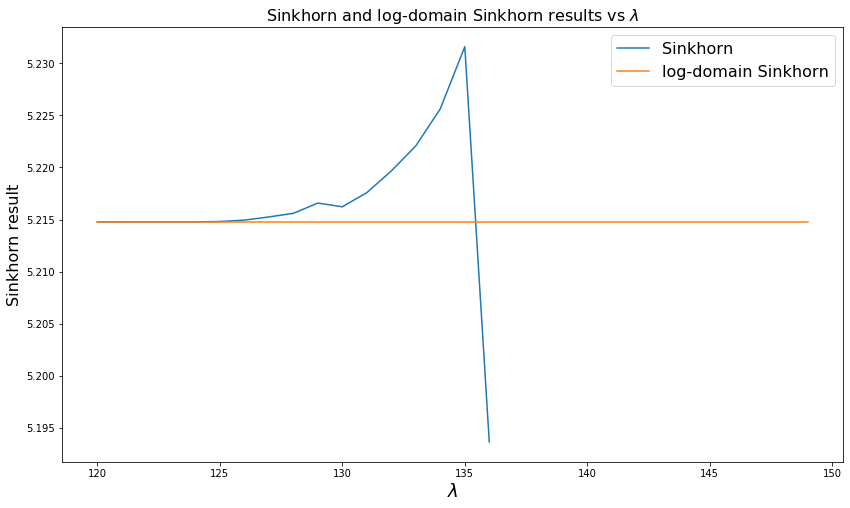

In [16]:
plt.figure(figsize = (14, 8))
plt.plot(lamda, skh_res, label = "Sinkhorn")
plt.plot(lamda, log_skh_res, label = "log-domain Sinkhorn")
plt.xlabel("$\lambda$", fontsize = 18)
plt.ylabel("Sinkhorn result", fontsize = 16)
plt.title("Sinkhorn and log-domain Sinkhorn results vs $\lambda$", fontsize = 16)
plt.legend(fontsize = 16)
pass

We can see that, with $P: Beta(2, 5)$ and $Q: Uniform(5, 6)$, the Sinkhorn algorithm produces inaccurate results with $\lambda > 125$, and the overflow/underflow occurs at $\lambda = 136$. On the other hand, the log-domain Sinkhorn continue to produce relatively accurate result up to $\lambda = 149$. 